PEGASUS Model evaluation on test set and fine tuning attempt

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requi

In [ ]:
from datasets import load_dataset
dataset_dialog = load_dataset("knkarthick/dialogsum")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
print(dataset_dialog)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})


In [ ]:
dataset_dialog['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [ ]:
test_dataset= dataset_dialog['test']

In [ ]:
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-large')
model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-large')

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_summary_batch(records):
    input_texts = records['dialogue']
    input_ids = tokenizer(["summarize: " + text for text in input_texts], return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    input_ids = input_ids['input_ids'].to(device)

    with torch.no_grad():
        output_ids = model.generate(input_ids, max_length=150, num_beams=4, early_stopping=True)

    summaries = [tokenizer.decode(g, skip_special_tokens=True) for g in output_ids]
    return {"generated_summary": summaries}

batch_size = 8
test_dataset = test_dataset.map(generate_summary_batch, batched=True, batch_size=batch_size)

# printing some generated summaries
for i in range(5):
    print(f"Dialogue: {test_dataset[i]['dialogue']}")
    print(f"Generated Summary: {test_dataset[i]['generated_summary']}")
    print("-" * 80)


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dialogue: #Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Person2#: Yes, sir. Go ahead.
#Person1#: Attention all staff... Effective immediately, all office communications are restricted to email correspondence and official memos. The use of Instant Message programs by employees during working hours is strictly prohibited.
#Person2#: Sir, does this apply to intra-office communications only? Or will it also restrict external communications?
#Person1#: It should apply to all communications, not only in this office between employees, but also any outside communications.
#Person2#: But sir, many employees use Instant Messaging to communicate with their clients.
#Person1#: They will just have to change their communication methods. I don't want any - one using Instant Messaging in this office. It wastes too much time! Now, please continue with th

Since the PEGASUS Model was originally trained on large dataset containing news articles, it is not likely expected that the generated summaries by the model will show good level of summarization incase of conversational data.
The generated summaries should improve in quality after fine-tuning the pegasus model on dialogsum data.

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=dd8f9ac8ef664b57761d7fc82cdc057f91592db7eb7176c8c0c91cbac5fac833
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
!pip install bert_score

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
#evaluation metrics
def calculate_metrics(reference, hypothesis):
    metrics = {}

    #METEOR and BLEU need tokenization of the references and summaries
    reference_tokens = nltk.word_tokenize(reference)
    hypothesis_tokens = nltk.word_tokenize(hypothesis)
    #BLEUscore
    smooth_fn = SmoothingFunction().method1
    metrics['BLEU'] = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smooth_fn)
    #ROUGEscore
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, hypothesis)
    metrics['ROUGE-1'] = rouge_scores['rouge1'].fmeasure
    metrics['ROUGE-2'] = rouge_scores['rouge2'].fmeasure
    metrics['ROUGE-L'] = rouge_scores['rougeL'].fmeasure
    #METEORscore
    metrics['METEOR'] = meteor_score([reference_tokens], hypothesis_tokens)
    #BERTScore
    P, R, F1 = bert_score([hypothesis], [reference], lang='en', model_type='bert-base-uncased', verbose=False)
    metrics['BERTScore_P'] = P.mean().item()
    metrics['BERTScore_R'] = R.mean().item()
    metrics['BERTScore_F1'] = F1.mean().item()
    #Cosine similarity
    vectorizer = TfidfVectorizer().fit_transform([reference, hypothesis])
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity(vectors)
    metrics['Cosine Similarity'] = cosine_sim[0, 1]

    return metrics

test_results = test_dataset.map(lambda example: calculate_metrics(example['summary'], example['generated_summary']))

import pandas as pd
results_df = pd.DataFrame(test_results)
print(f"Evaluation Metrics for PEGASUS Model\n")
print(results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].describe())


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

              BLEU      ROUGE-1      ROUGE-2      ROUGE-L       METEOR  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean      0.054741     0.234870     0.059967     0.189729     0.255223   
std       0.051604     0.118640     0.087242     0.105772     0.119527   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.023567     0.153846     0.000000     0.117647     0.168503   
50%       0.042689     0.227273     0.019143     0.173913     0.244264   
75%       0.066382     0.310536     0.094564     0.242424     0.328257   
max       0.570282     0.761905     0.631579     0.761905     0.731129   

       Cosine Similarity  BERTScore_P  BERTScore_R  BERTScore_F1  
count        1500.000000  1500.000000  1500.000000   1500.000000  
mean            0.175259     0.507048     0.549804      0.525013  
std             0.110023     0.079205     0.088722      0.075776  
min             0.000000     0.253785     0.210340      0.267892 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(f"Evaluation Metrics for PEGASUS Model\n")

print(results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].describe())


Evaluation Metrics for PEGASUS Model

              BLEU      ROUGE-1      ROUGE-2      ROUGE-L       METEOR  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean      0.054741     0.234870     0.059967     0.189729     0.255223   
std       0.051604     0.118640     0.087242     0.105772     0.119527   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.023567     0.153846     0.000000     0.117647     0.168503   
50%       0.042689     0.227273     0.019143     0.173913     0.244264   
75%       0.066382     0.310536     0.094564     0.242424     0.328257   
max       0.570282     0.761905     0.631579     0.761905     0.731129   

       Cosine Similarity  BERTScore_P  BERTScore_R  BERTScore_F1  
count        1500.000000  1500.000000  1500.000000   1500.000000  
mean            0.175259     0.507048     0.549804      0.525013  
std             0.110023     0.079205     0.088722      0.075776  
min             0.000000   

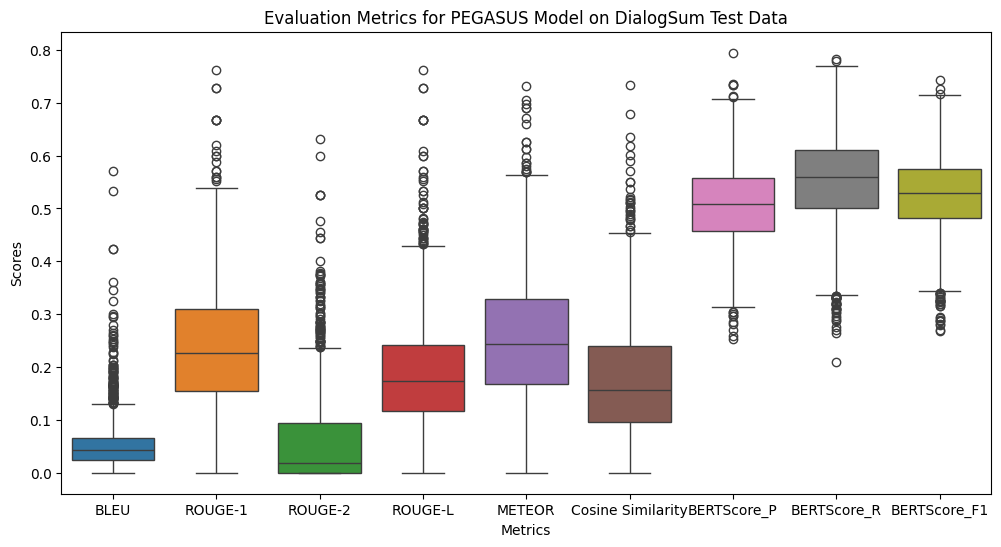

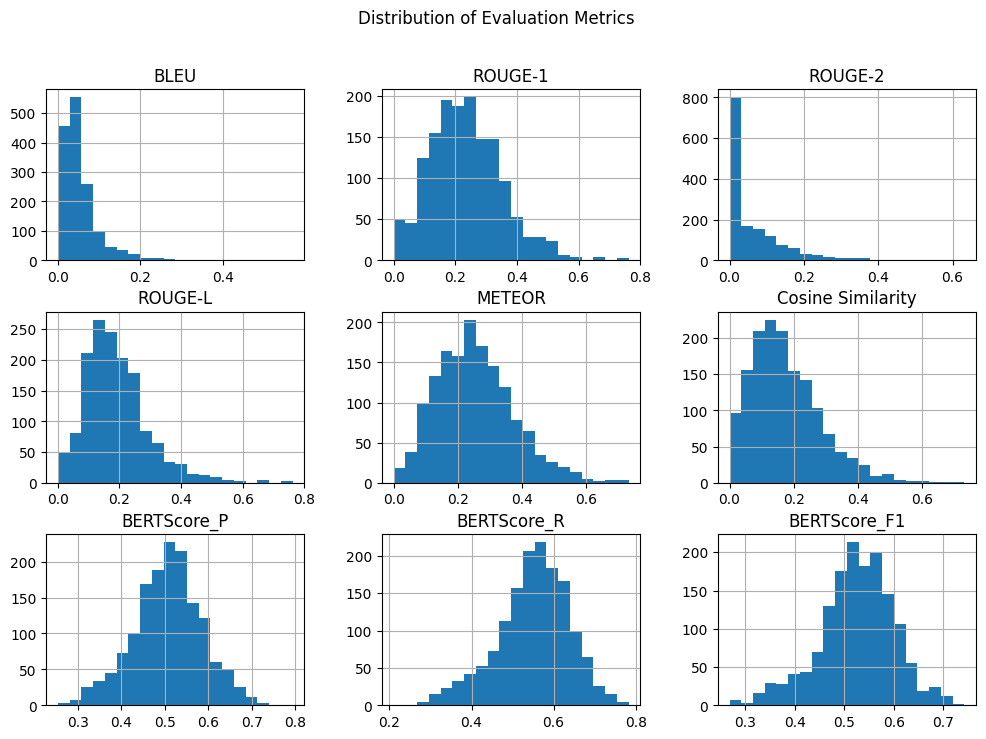

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']])
plt.title('Evaluation Metrics for PEGASUS Model on DialogSum Test Data')
plt.ylabel('Scores')
plt.xlabel('Metrics')
plt.show()

# Histogram
results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribution of Evaluation Metrics')
plt.show()

#**PEGASUS-FINE TUNING**

In [ ]:
pip install transformers datasets torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from datasets import load_dataset
dataset_ft = load_dataset("knkarthick/dialogsum")
train_dataset_ft = dataset_ft['train']
val_dataset = dataset_ft['validation']
test_dataset = dataset_ft['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-large')
model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-large')

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

In [ ]:
def preprocess_function(records):
    inputs = ["summarize: " + dialogue for dialogue in records["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(records["summary"], max_length=150, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

# tokenization of the datasets
train_dataset = train_dataset_ft.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
import optuna
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, GenerationConfig

#generation configuration
generation_config = GenerationConfig(
    max_length=256,
    num_beams=8,
    length_penalty=0.8,
    forced_eos_token_id=1
)

def objective(trial):
    #hyperparameters options for optimization
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    num_train_epochs = trial.suggest_int('num_train_epochs', 1, 3)

    # setting training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=weight_decay,
        save_total_limit=3,
        num_train_epochs=num_train_epochs,
        predict_with_generate=True,
        logging_dir='./logs',
        logging_steps=10,
        report_to="none"
    )

    # Initializing trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
    )

  #running the trainer
    trainer.train()

    model.generation_config = generation_config
    eval_results = trainer.evaluate(eval_dataset=val_dataset)
    return eval_results['eval_loss']

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best hyperparameters: ", study.best_params)
print("Best validation loss: ", study.best_value)

[I 2024-08-12 22:02:03,713] A new study created in memory with name: no-name-41a3a773-9479-40f3-b9db-8c0ca6baa289
<ipython-input-11-627999f72fb5>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-11-627999f72fb5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


Epoch,Training Loss,Validation Loss
1,0.258800,0.237471
2,0.307800,0.236395


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-

[I 2024-08-12 22:39:56,366] Trial 0 finished with value: 0.2363952249288559 and parameters: {'learning_rate': 1.5222728155331081e-05, 'batch_size': 8, 'weight_decay': 0.00015926292583552795, 'num_train_epochs': 2}. Best is trial 0 with value: 0.2363952249288559.
<ipython-input-11-627999f72fb5>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-11-627999f72fb5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` 

Epoch,Training Loss,Validation Loss
1,0.243300,0.233337


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-

[I 2024-08-12 22:59:04,630] Trial 1 finished with value: 0.23333735764026642 and parameters: {'learning_rate': 6.899469276075781e-05, 'batch_size': 8, 'weight_decay': 0.00026475949255318963, 'num_train_epochs': 1}. Best is trial 1 with value: 0.23333735764026642.
<ipython-input-11-627999f72fb5>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-11-627999f72fb5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy`

Epoch,Training Loss,Validation Loss
1,0.243300,0.234006
2,0.282900,0.232482
3,0.219000,0.232610


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-

[I 2024-08-12 23:55:32,790] Trial 2 finished with value: 0.23261019587516785 and parameters: {'learning_rate': 1.133254786477566e-05, 'batch_size': 8, 'weight_decay': 9.091747858470435e-05, 'num_train_epochs': 3}. Best is trial 2 with value: 0.23261019587516785.
<ipython-input-11-627999f72fb5>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-11-627999f72fb5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` 

Epoch,Training Loss,Validation Loss
1,0.229500,0.235931
2,0.271300,0.234601


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-

[I 2024-08-13 00:33:50,967] Trial 3 finished with value: 0.23460055887699127 and parameters: {'learning_rate': 1.3624269063003328e-05, 'batch_size': 8, 'weight_decay': 1.411620927088141e-06, 'num_train_epochs': 2}. Best is trial 2 with value: 0.23261019587516785.
<ipython-input-11-627999f72fb5>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-11-627999f72fb5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy`

Epoch,Training Loss,Validation Loss


[W 2024-08-13 00:33:52,825] Trial 4 failed with parameters: {'learning_rate': 2.002843398060292e-05, 'batch_size': 16, 'weight_decay': 0.00042849075158900486, 'num_train_epochs': 3} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 880.00 MiB. GPU ').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-11-627999f72fb5>", line 45, in objective
    trainer.train()
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1932, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2268, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 3324, in training_step
    self.accelerator.backward(loss, **kwargs)
  File "/usr/local/li

OutOfMemoryError: CUDA out of memory. Tried to allocate 880.00 MiB. GPU 

In [ ]:
best_params = study.best_params
best_params

{'learning_rate': 1.133254786477566e-05,
 'batch_size': 8,
 'weight_decay': 9.091747858470435e-05,
 'num_train_epochs': 3}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate'],
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    weight_decay=best_params['weight_decay'],
    save_total_limit=3,
    num_train_epochs=best_params['num_train_epochs'],
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, GenerationConfig
#training arguments with the best hyperparameters
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate= 1.133254786477566e-05,
    per_device_train_batch_size= 8,
    per_device_eval_batch_size= 8,
    weight_decay= 9.091747858470435e-05,
    save_total_limit=3,
    num_train_epochs= 3,
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#with the best hyperparameters
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)
# running the trainer for fine-tuning
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 

FINE TUNING KEEPING IN MIND MEMORY USAGE

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset

In [ ]:
dataset_ft = load_dataset("knkarthick/dialogsum")
train_dataset_ft = dataset_ft['train']
val_dataset = dataset_ft['validation']
test_dataset = dataset_ft['test']

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
model_name = "google/pegasus-large"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def preprocess_function(examples):
    inputs = ["summarize: " + dialogue for dialogue in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")
    labels = tokenizer(examples["summary"], max_length=64, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_dataset_ft.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1.133254786477566e-05,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=9.091747858470435e-05,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=4,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer.train()

Epoch,Training Loss,Validation Loss
0,0.858400,0.683815
2,0.916700,0.668561


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-

Epoch,Training Loss,Validation Loss
0,0.858400,0.683815
2,0.822100,0.674178


TrainOutput(global_step=4671, training_loss=1.6833746711693798, metrics={'train_runtime': 6197.7325, 'train_samples_per_second': 6.031, 'train_steps_per_second': 0.754, 'total_flos': 2.6993376557531136e+16, 'train_loss': 1.6833746711693798, 'epoch': 2.999036918138042})

The fine tuning of Pegasus Model could not be performed on the model because of CUDA out of memory issue, the RAM was exceeding 15GB and attempts were made to change runtime and run the training on A100 GPU. The GPU was not available during this time and I tried running this on a lower GPU. Considering the nearing project deadline, a decision was made to continue working on this issue after submission, as future work and try to look improvise on my research.

This research project gave me a very good expore to transformer based models, and I would love to continue exploring and learning even more!